анализ активности студентов онлайн курса на платформе stepik (предсказание оттока пользователей с курса)

submissions_train.csv - данные о времени и статусах сабмитов к практическим заданиям


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set(rc={'figure.figsize': (9, 6)}) #изменим дефолтный размер графика

Ознакомимся с форматом данных:

**events_train.csv** - данные о действиях, которые совершают студенты со стэпами

**step_id** - id стэпа

**user_id** - анонимизированный id юзера

**timestamp** - время наступления события в формате unix date

**action** - событие, возможные значения:

**discovered** - пользователь перешел на стэп

**viewed** - просмотр шага

**started_attempt** - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага

**passed** - удачное решение практического шага
    
**submissions_train.csv** - данные о времени и статусах сабмитов к практическим заданиям

**step_id** - id стэпа

**timestamp** - время отправки решения в формате unix date

**submission_status** - статус решения

**user_id** - анонимизированный id юзера

In [ ]:
events_train = pd.read_csv('C:/datadata/event_data_train.csv')
events_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [ ]:
submissions_train = pd.read_csv('C:/datadata/submissions_data_train.csv')
submissions_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [ ]:
events_train.action.unique() #посмотрим какие уникальные значения у переменной action

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [ ]:
events_train['date'] = pd.to_datetime(events_train.timestamp, unit='s') #изменим формат timestamp для удобной работы с конкретными временными промежутками
events_train['day'] = events_train.date.dt.date

In [ ]:
submissions_train['date'] = pd.to_datetime(submissions_train.timestamp, unit='s')
submissions_train['day'] = submissions_train.date.dt.date

Привычный формат времени позволит провести небольшую проверку данных на валидность.

In [ ]:
print(events_train.date.min(), events_train.date.max()) # Посмотрим на минимальное и максимальное значение

2015-06-15 04:00:48 2018-05-19 23:33:31


Посмотрим на кол-во уникальных юзеров для каждого дня

<AxesSubplot:xlabel='day'>

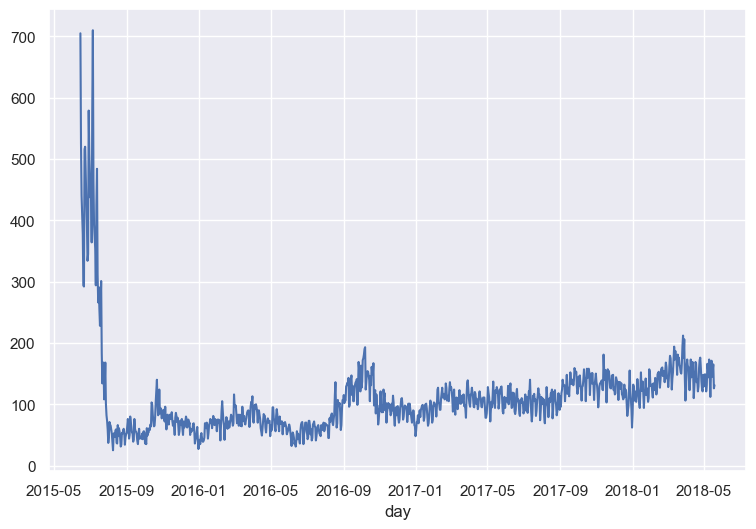

In [ ]:
events_train.groupby('day') \
    .user_id.nunique().plot()

In [ ]:
#events_data.groupby('day').user_id.nunique().plot(figsize=(20,10))

Посчитаем для каждого пользователя количество пройденных степов и количество верных сабмитов посмотрим на эти распределения

<AxesSubplot:>

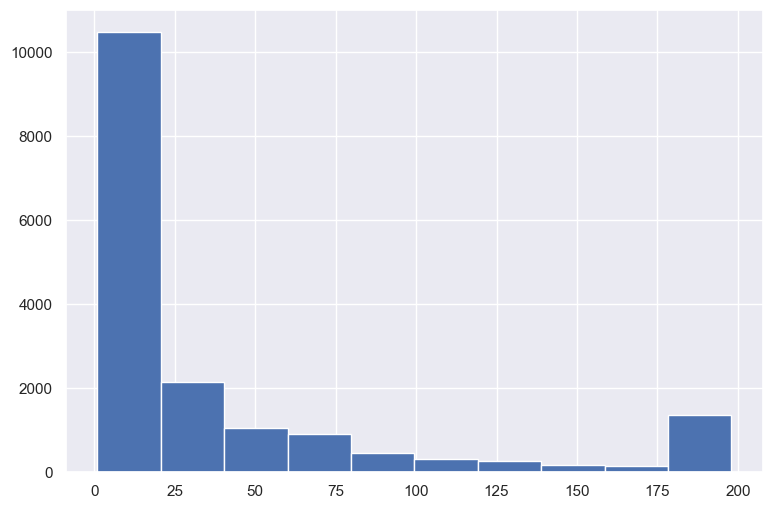

In [ ]:
events_train[events_train.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .aggregate({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()

Мы получили довольно ожидаемую картину, большое кол-во пользователей которые начали курс и прошли немного шагов, с увеличением кол-во шагов кол-во пользователей падает, в правой части графика видим группу пользователей которая прошла курс до конца. Основная проблема в том что на первом этапе фильтрации мы могли потерять большое кол-во пользователей (тех что не прошел ни один степ). Т.е. нам хотелось бы учитывать и тех пользователей у которых в action нет ни одного "passed". Для этого воспользуемся pivot table

In [ ]:
users_events_data = events_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<AxesSubplot:>

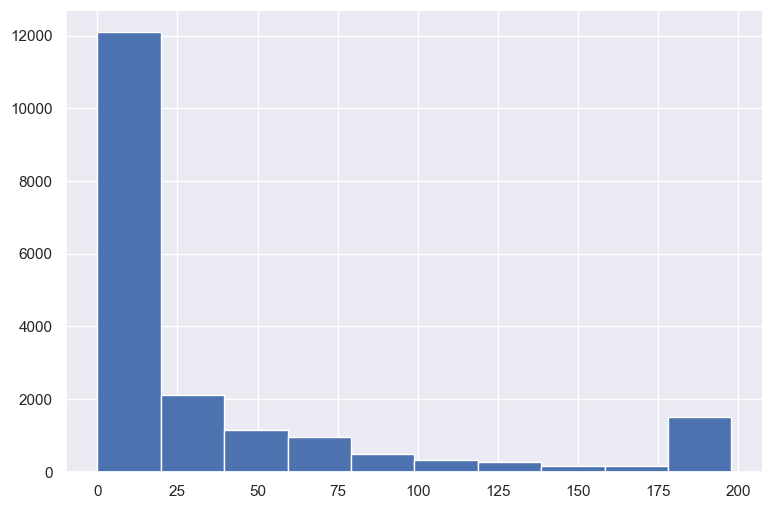

In [ ]:
events_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().discovered.hist()

In [ ]:
users_scores = submissions_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()

Для дальнейшего анализа и прогнозов ухода пользователя с курса нам необходимо установить порог длительности отсутствия на курсе, после которого пользователя можно считать ушедшим. Для этого посмотрим какие временные промежутки между прохождениями степов делают пользователи.

In [ ]:
events_train[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list).head() #отберем для каждого пользователя по одному timestamp на день, сгрупируем по пользователю. Т.е. получим для каджого пользователя список timestemp'ов дней когда он был на курсе (по одному на каждый день).

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [ ]:
gap_data = events_train[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values #теперь посмотрим разницу между двумя соседними timestamp чтобы понять сколько пользователи отсутствуют между занятиями

In [ ]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0)) #сохранили массив из промежутков между действиями всех пользователей

In [ ]:
gap_data = gap_data / (24 * 60 * 60)

<AxesSubplot:>

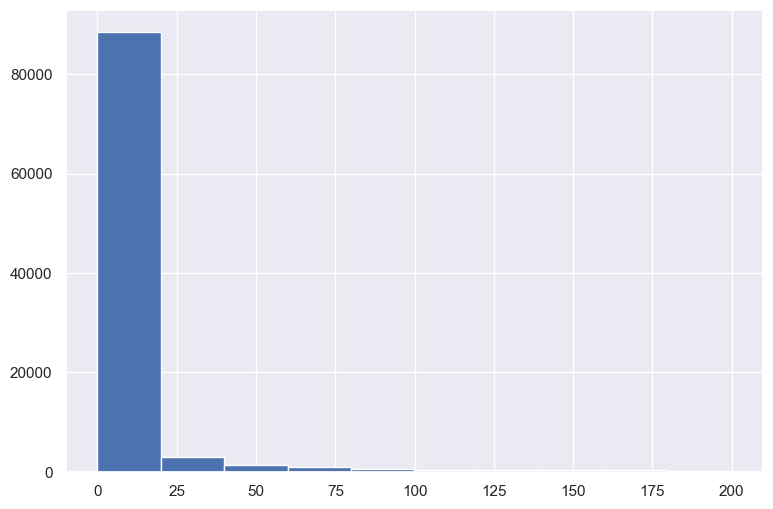

In [ ]:
gap_data[gap_data < 200].hist() #нарисуем диаграмму отфильтровав слишком большие промежутки

In [ ]:
gap_data.quantile(0.90) #только 10% перерывов между действиями составляет больше 18 дней.

18.325995370370403

На основании сделанных выводов установим порог и разметим наши данные. 

In [ ]:
events_train.tail() #будем производить отсчет от последнего наблюдения в наших данных - 1526772811

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [ ]:
users_data = events_train.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename(columns={'timestamp': 'last_timestamp'}) #сгруппируем данные по пользователю сохранив для каждого его последний timestamp 

In [ ]:
now = 1526772811
drop_out_treshold = 2592000 #установим порог в 30дн

In [ ]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold #добавим к датафрейму новую колонку по нашему условию - отсутсвие на платформе больше 30дней

In [ ]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [ ]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [ ]:
users_data = users_data.merge(users_scores, on='user_id', how='outer') #объединим полученные данные

In [ ]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [ ]:
users_data = users_data.fillna(0) #заполним пропущенные значения нулями

In [ ]:
users_data = users_data.merge(users_events_data, how='outer')

In [ ]:
users_days = events_train.groupby('user_id').day.nunique().to_frame().reset_index() #посмотрим сколько уникальных дней был на платформе каждый из пользователей

In [ ]:
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [ ]:
users_data = users_data.merge(users_days, how='outer')

In [ ]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [ ]:
users_data['passed_corse'] = users_data.passed > 170 #зная кол-во степов на курсе заведем еще одну переменную "прошел пользователь курс или нет"

In [ ]:
users_data.groupby('passed_corse').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_corse,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [ ]:
users_data[users_data.passed_corse].day.median() #50% пользователей курса тратят на прохождение больше 20дн

20.0

<AxesSubplot:>

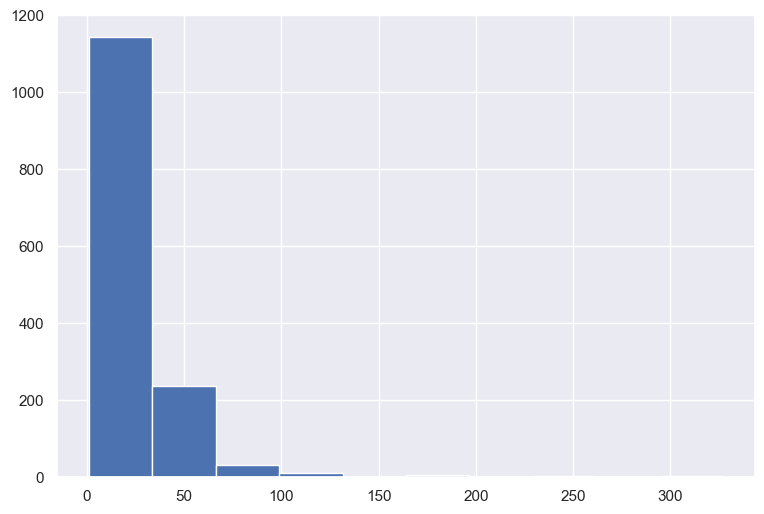

In [ ]:
users_data[users_data.passed_corse].day.hist()

Необходимо сделать прогноз об уходе человека с курса как можно раньше, поэтому для обучения возьмем данные для каждого пользователя за первые три дня его активности

In [ ]:
user_min_time = events_train.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1) #время начала курса для каждого из пользователей

In [ ]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [ ]:
users_data = users_data.merge(user_min_time, how='outer')

In [ ]:
events_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [ ]:
event_data_train = pd.DataFrame()

In [ ]:
events_train['user_time'] = events_train.user_id.map(str) + '_' + events_train.timestamp.map(str) #заведем новую колонку в качестве значения которой склеим id пользователя и timestamp каждого действия

In [ ]:
events_train.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [ ]:
learning_time_threshold = 3 * 24 * 60 * 60 #порог который мы установили для данных для обучения - 3дня
learning_time_threshold

259200

In [ ]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str) #посчитаем порог для каждого пользователя так же склеим значение с id юзера

In [ ]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [ ]:
events_train = events_train.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how ='outer') 

In [ ]:
events_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [ ]:
event_data_train = events_train[events_train.user_time <= events_train.user_learning_time_threshold] #отберем для каждого пользователя только те данные которые вписываются в его индивидуальный порог 3х дней

In [ ]:
event_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


Проделаем те же операции со вторым набором данных

In [ ]:
submissions_train['users_time'] = submissions_train.user_id.map(str) + '_' + submissions_train.timestamp.map(str)
submissions_train = submissions_train.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_train[submissions_train.users_time <= submissions_train.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [ ]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns={'day': 'days'}) #заведем датафрейм с необходимыми фичами, начнем с кол-ва уникальных дней у пользователя (уже в пределах порога)

In [ ]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'}) #посмотрим сколько у каждого пользователя было уникальных степов за 3 дня

In [ ]:
X = X.merge(steps_tried, on='user_id', how='outer') 

Добавим информацию о кол-ве правильных и неправильных попыток

In [ ]:
X = X.merge(submissions_data_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index())

In [ ]:
X['correct_ration'] = X.correct / (X.correct + X.wrong) 

In [ ]:
X = X.merge(event_data_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0) \
            .reset_index()[['user_id', 'viewed']], how = 'outer') #добавим информацию о кол-ве просмотренных степов

In [ ]:
X = X.fillna(0)

In [ ]:
X = X.merge(users_data[['user_id', 'passed_corse', 'is_gone_user']], how='outer') 

In [ ]:
X = X[~((X.is_gone_user == False) & (X.passed_corse == False))] #отбросим пользователей которые начали курс, не закончили и еще не ушли с платформы

Теперь в Х у нас только те пользователи которые дропнулись с курса или прошли его

In [ ]:
X.groupby(['passed_corse', 'is_gone_user']).user_id.count() #все кто не прошли курс являются дропнувшимися, а те кто прошли могут считаться и дропнувшимися и нет(недавно закончил курс), таким образом целевой переменной можем взять passed_corse

passed_corse  is_gone_user
False         True            16560
True          False             141
              True             1284
Name: user_id, dtype: int64

In [ ]:
X.head()

,days,steps_tried,correct,wrong,correct_ration,viewed,passed_corse,is_gone_user
user_id,,,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9,False,True
3,1.0,4.0,4.0,4.0,0.50,20,False,True
8,1.0,11.0,9.0,21.0,0.30,154,False,True
14,1.0,1.0,0.0,1.0,0.00,9,False,True
16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [ ]:
X= X.set_index(X.user_id)
X = X.drop('user_id', axis=1) #id пользователя не несет полезной информации для модели перенесем в индекс и дропнем 

In [ ]:
y = X.passed_corse.map(int)

In [ ]:
y.head()

user_id
2     0
3     0
8     0
14    0
16    1
Name: passed_corse, dtype: int64

In [ ]:
X = X.drop(['passed_corse', 'is_gone_user'], axis=1)

In [ ]:
X.head() 

,days,steps_tried,correct,wrong,correct_ration,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


Посмотрим насколько наши данные информативны и подходят для обучения простой модели (логистической регрессии или дерева решений)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

clf = LogisticRegressionCV(cv=5) 

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

clf.fit(X_train, y_train)
print("Score:", clf.score(X_test,y_test))
print("Cross_val_score:", cross_val_score(clf,X_train,y_train,cv=4).mean())
y_pred = clf.predict(X_test)
print("f1:", f1_score(y_pred,y_test))

Score: 0.9329997219905477
Cross_val_score: 0.9200722824576035
f1: 0.23492063492063495


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(criterion='entropy')
parameters = {'max_depth': range(3,6), 'max_leaf_nodes':range(6,15), 'min_samples_leaf': range(1,4),'min_samples_split':range(2,5)}
grid_search_cv_clf = GridSearchCV(dt,parameters,cv=4)
grid_search_cv_clf.fit(X_train,y_train)

model = grid_search_cv_clf.best_estimator_
print("Score:", model.score(X_test,y_test))
print("Cross_val_score:", cross_val_score(model,X_train,y_train,cv=4).mean())
y_pred = model.predict(X_test)
print("f1:", f1_score(y_pred,y_test))

Score: 0.931053655824298
Cross_val_score: 0.9188907422852377
f1: 0.23456790123456792


К сожалению метрики моделей оставляют желать лучшего,  мы получаем довольно большую точность из-за дисбалансировки классов, для адекватной оценки необходимо ориентироваться на f1.